*Last Modified*: Feb 27th, 2023. [OI]

## Swarm-C thermospheric neutral density data derived via GPS receiver data
Downloaded from http://thermosphere.tudelft.nl/

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np
from pandas import read_csv
import pandas as pd
import datetime as df
import astropy
from pymsis import msis
from astropy.coordinates import SkyCoord
from datetime import datetime, timedelta
from astropy.constants import R_earth
import astropy.units as u
from astropy import time

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 11}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=11) 
matplotlib.rc('ytick', labelsize=11) 

In [5]:
data = read_csv("data_swarm/SC_DNS_POD_2022_02_v01.txt", sep='\s+', on_bad_lines='skip')
data

,date,time,UTC,alt,lon,lat,lst,arglat,dens_x
0,2022-02-01,00:00:00.000,UTC,454395.992,-27.387471,-74.715091,21.949,254.842263,8.322190e-13
1,2022-02-01,00:00:30.000,UTC,454773.303,-26.068009,-76.597913,22.046,256.769263,8.309363e-13
2,2022-02-01,00:01:00.000,UTC,455104.136,-24.288132,-78.469489,22.173,258.696203,8.302464e-13
3,2022-02-01,00:01:30.000,UTC,455387.295,-21.786226,-80.323591,22.348,260.623088,8.299015e-13
4,2022-02-01,00:02:00.000,UTC,455621.760,-18.066403,-82.148149,22.604,262.549927,8.298851e-13
...,...,...,...,...,...,...,...,...,...
80635,2022-02-28,23:57:30.000,UTC,434822.225,-73.193383,-24.086676,18.872,203.995167,1.142125e-12
80636,2022-02-28,23:58:00.000,UTC,435597.640,-73.209766,-26.022678,18.879,205.925905,1.131840e-12
80637,2022-02-28,23:58:30.000,UTC,436393.612,-73.222536,-27.957749,18.886,207.856446,1.120840e-12
80638,2022-02-28,23:59:00.000,UTC,437207.530,-73.231244,-29.891850,18.894,209.786792,1.109165e-12


In [6]:
data_timestamps = []


In [7]:
# save all timestamps
for ii in range(np.shape(data)[0]):
    data_timestamps.append(pd.Timestamp(year=int(data["date"][ii][:4]), 
                                    month=int(data["date"][ii][5:7]), 
                                    day=int(data["date"][ii][8:11]),
                                    hour=int(data["time"][ii][:2]), 
                                    minute=int(data["time"][ii][3:5]), 
                                    second=int(data["time"][ii][6:8]), 
                                    microsecond=int(data["time"][ii][9:])))

In [8]:
# coordinate transformation
coords_geodetic = astropy.coordinates.EarthLocation.from_geodetic(lon=data["lon"]*u.deg, 
                                                         lat=data["lat"]*u.deg, 
                                                         height=data["alt"]*u.m, 
                                                         ellipsoid="GRS80")

x, y, z = coords_geodetic.geocentric

In [9]:
# descibe in spherical coordinates
coords_geocentric = astropy.coordinates.cartesian_to_spherical(x=x, y=y,z=z)
#coords_geocentric

In [10]:
san_diego_lon, san_diego_lat = -117.1611, 32.7157

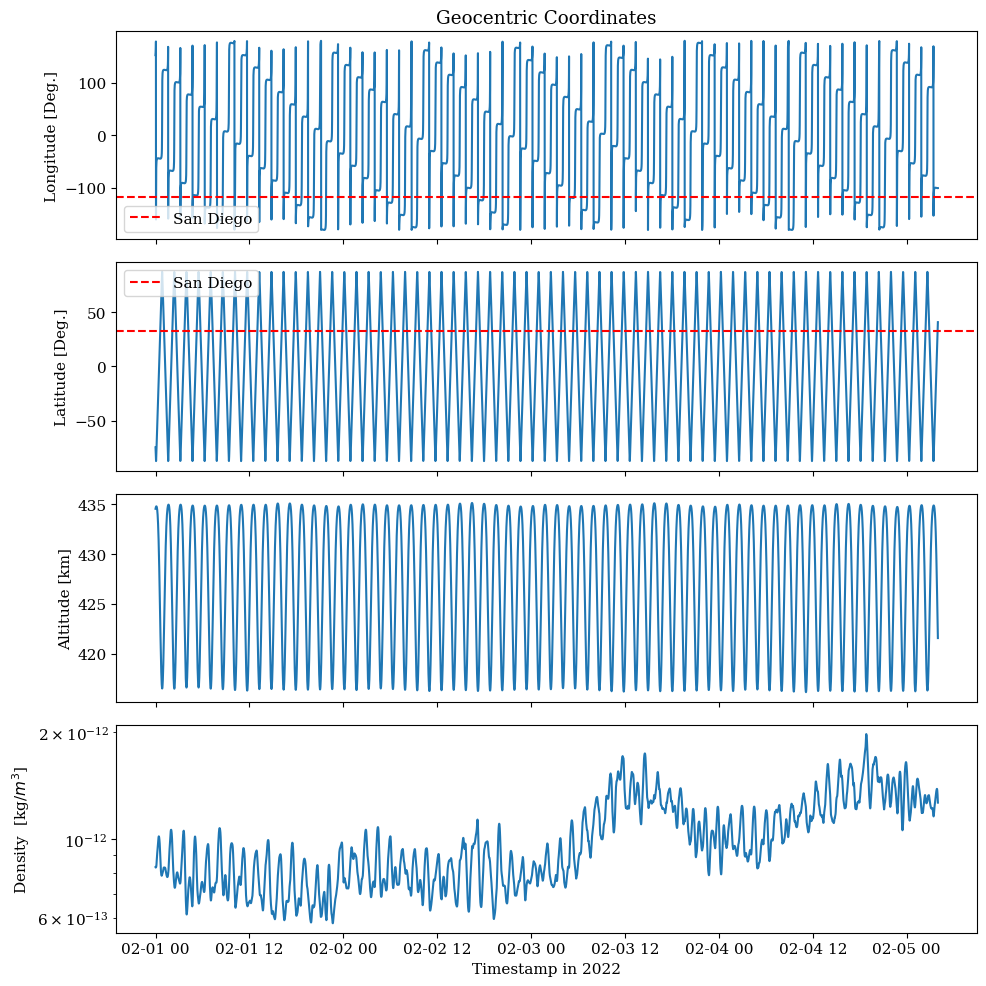

In [11]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(10, 10))
max_timestamp = 12000
ax[0].plot(data_timestamps[:max_timestamp], coords_geocentric[2].to(u.deg)[:max_timestamp]-180*u.deg)
ax[0].axhline(san_diego_lon, c="r", ls="--", label="San Diego")
ax[0].set_ylabel("Longitude [Deg.]")
ax[1].plot(data_timestamps[:max_timestamp], coords_geocentric[1].to(u.deg)[:max_timestamp])
ax[1].set_ylabel("Latitude [Deg.]")
ax[1].axhline(san_diego_lat, c="r", ls="--", label="San Diego")
ax[2].plot(data_timestamps[:max_timestamp], (coords_geocentric[0] - R_earth).to(u.km)[:max_timestamp])
ax[2].set_ylabel("Altitude [km]")
ax[3].plot(data_timestamps[:max_timestamp], data["dens_x"][:max_timestamp])
ax[3].set_ylabel(r"Density  [kg/$m^3$]")
ax[0].set_title("Geocentric Coordinates")
ax[3].set_xlabel("Timestamp in 2022")
_ = ax[0].legend()
_ = ax[1].legend()
_ = ax[3].set_yscale("log")
plt.tight_layout()
plt.savefig("figs/Swarm_c_location_and_observations.png", dpi=600)

## Read in F10.7

In [12]:
f10p7_msis, f10p7a_msis, ap_msis = msis.get_f107_ap(dates=data_timestamps[:max_timestamp])

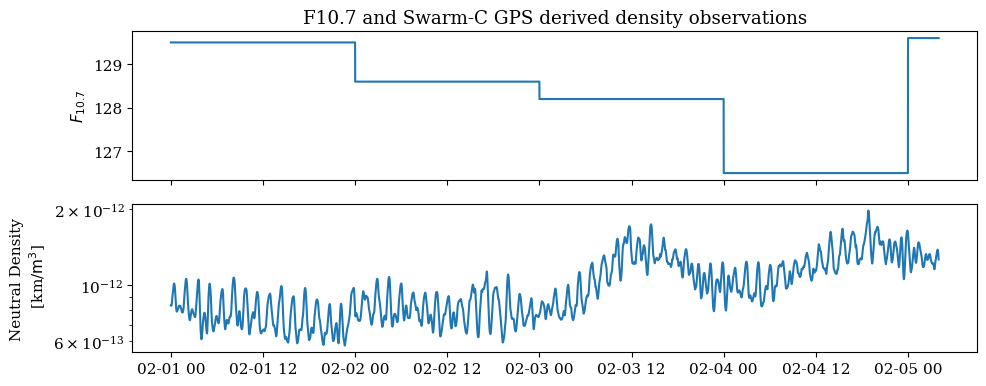

In [13]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 4))
ax[0].plot(data_timestamps[:max_timestamp], f10p7_msis, label="F10.7")
#ax[0].plot(data_timestamps[:max_timestamp], f10p7a_msis, label="F10.7 81-day average")
ax[1].plot(data_timestamps[:max_timestamp], data["dens_x"][:max_timestamp])
ax[1].set_yscale("log")
ax[0].set_ylabel("$F_{10.7}$")
ax[0].set_title("F10.7 and Swarm-C GPS derived density observations")
#ax[0].legend()
_ = ax[1].set_ylabel("Neutral Density\n [km/$\mathrm{m}^3$]")
plt.tight_layout()
plt.savefig("figs/swarm_meassurements_and_f10.7.png", dpi=600)

## Intersection with San Diego

In [14]:
index_lon = np.where(np.abs(coords_geocentric[2].to(u.deg)[:max_timestamp]-180*u.deg - san_diego_lon*u.deg) < 3*u.deg)

In [15]:
index_lat = np.where(np.abs(coords_geocentric[1].to(u.deg)[:max_timestamp] - san_diego_lat*u.deg) < 1*u.deg)

In [16]:
np.intersect1d(index_lon, index_lat)

array([ 630, 6406])

## Read in 1D-GITM Results

In [16]:
# Add Exasim package to python search path
cdir = os.getcwd()
ii = cdir.find("Exasim")
exec(open(cdir[0:(ii + 6)] + "/Installation/setpath.py").read())

==> Exasim src ...



In [17]:
# import internal modules
import Preprocessing, Postprocessing, Gencode

In [20]:
# fidelity
fidelity = "f1"

In [21]:
parameters = np.load(cdir[:-10] + "solutions/" + str(fidelity) + "/parameters.npy", allow_pickle=True).item()
pde = np.load(cdir[:-10] + "solutions/" + str(fidelity) + "/pde.npy", allow_pickle=True).item()
mesh = np.load(cdir[:-10] + "solutions/" + str(fidelity) + "/mesh.npy", allow_pickle=True).item()
dmd = np.load(cdir[:-10] + "solutions/" + str(fidelity) + "/dmd.npy", allow_pickle=True)
master = np.load(cdir[:-10] + "solutions/" + str(fidelity) + "/master.npy", allow_pickle=True).item()

In [35]:
sol = Postprocessing.fetchsolution(pde, master, dmd, cdir[:-10] + "solutions/"+ str(fidelity) + "/dataout")
np.save(cdir[:-10] + "solutions/" + str(fidelity) + "/sol.npy", sol)

In [33]:
n_components, n_solution, n_resolution, n_timestamp = np.shape(sol)
print(np.shape(sol))

(4, 6, 40, 191)


In [25]:
# get parameters
rho0 = pde["physicsparam"][19]
H0 = pde["physicsparam"][17]
T0 = pde["physicsparam"][18]

In [26]:
computational_grid = mesh["dgnodes"].flatten("F")
phys_grid = ((computational_grid * float(H0) - R_earth.value) * u.m).to(u.km)

In [27]:
rho = np.exp(sol[:, 0, :, :]).flatten("F")
vr = sol[:, 1, :, :].flatten("F") / np.sqrt(rho)
T = sol[:, 2, :, :].flatten("F") / np.sqrt(rho)

In [28]:
time_stamp_gitm = []
for ii in range(n_timestamp):
    time_stamp_gitm.append(datetime.strptime(parameters["date"], '%Y-%m-%d %H:%M:%S') + timedelta(minutes=30)*ii)

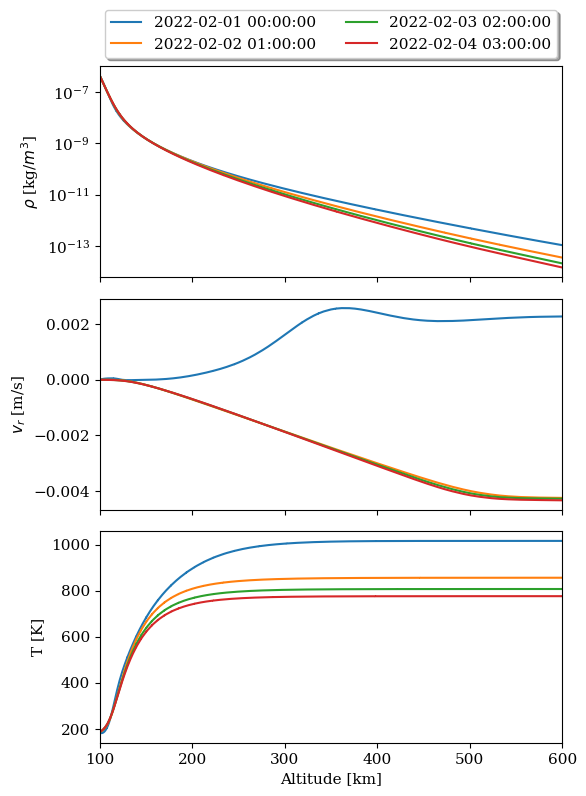

In [29]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6, 8))

for ii in np.arange(0, n_timestamp, 50):
    # solution
    rho = np.exp(sol[:, 0, :, ii]).flatten("F")
    vr = sol[:, 1, :, ii].flatten("F") / np.sqrt(rho)
    T = sol[:, 2, :, ii].flatten("F") / np.sqrt(rho)
    # plot solution
    ax[0].plot(phys_grid, rho*float(rho0), label=str(time_stamp_gitm[ii]))
    ax[1].plot(phys_grid, vr)
    ax[2].plot(phys_grid, T*float(T0))

ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, fancybox=True, shadow=True)
ax[0].set_ylabel(r"$\rho$ [kg/$m^3$]")
ax[1].set_ylabel(r"$v_{r}$ [m/s]")
ax[2].set_ylabel(r"T [K]")

ax[2].set_xlabel("Altitude [km]")
ax[2].set_xticks([100, 200, 300, 400, 500, 600])
ax[2].set_xlim(100, 600)
ax[0].set_yscale("log")
#ax[0].set_title("2022-02-05 00-00-0000")
plt.tight_layout()
plt.savefig("../figs/GITM_1D_results_f0.png", dpi=600)

In [30]:
np.argmin(np.abs(phys_grid.to(u.km).value - 400))/n_components

32.75

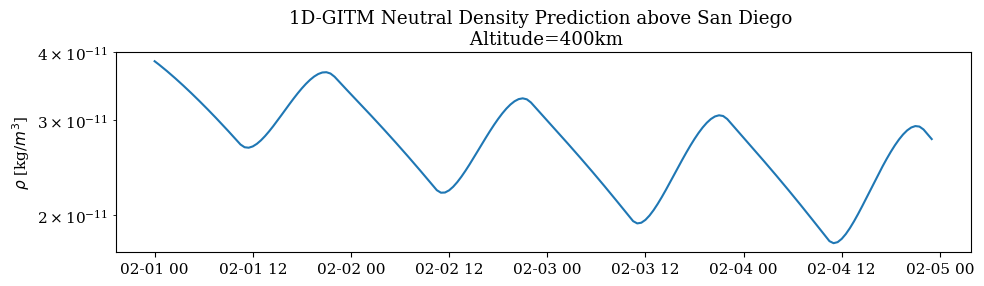

In [31]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(time_stamp_gitm,  np.exp(sol[1, 0, 25, :]).flatten("F")*float(rho0))
ax.set_title("1D-GITM Neutral Density Prediction above San Diego \n Altitude=400km")
ax.set_ylabel(r"$\rho$ [kg/$m^3$]")
ax.set_yscale("log")
plt.tight_layout()
plt.savefig("figs/1d_gitm_san_diego_400_altitude.png", dpi=400)